## Setup

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
from shapely import wkb
print(os.getcwd())

from neo4j import GraphDatabase
import psycopg2
from shapely.geometry import Point



/home/jovyan/work/business-opportunity-graph/notebooks


### Definitions

In [9]:
#from gemini

def get_degrees(tx, node_label: str = None, rel_type: str = None) -> dict[int, int]:
    # Construct the node pattern: (n) if node_label is None/empty, or (n:Label) otherwise
    node_pattern = f"(n{f':{node_label}' if node_label else ''})"

    # Construct the relationship pattern: -[]- if rel_type is None/empty, or -[:TYPE]- otherwise
    rel_pattern = f"-[r{f':{rel_type}' if rel_type else ''}]-"

    query = f"""
    MATCH {node_pattern}{rel_pattern}()
    RETURN elementId(n) as id, count(r) as degree
    """
    
    result = tx.run(query)
    # The result.data() method returns a list of dictionaries, 
    # e.g., [{'id': '4:0', 'degree': 5}, {'id': '4:1', 'degree': 3}]
    res = result.data()
    return res

In [6]:
#functions from Graph Data Science with Neo4J by Estelle Scifo
# def get_degrees(tx, node_label: str, rel_type: str) -> dict[int, int]:
#     query = f"""
#     MATCH (n:{node_label})-[r:{rel_type}]-() 
#     RETURN elementId(n) as id, count(r) as degree
#     """
#     result = tx.run(query)
#     res = result.data()
#     return res



def plot_degree_distribution(degrees: pd.Series, log_mode: bool = False):
    # define figure and subplots
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.subplots(1, 1)

    # compute and draw degree distribution
    distribution = degrees.value_counts().sort_index()
    distribution.plot(
        ax=ax1, 
        marker="o", color="k",
        title="Degree Distribution", xlabel="Degree", ylabel="nbOccurrences",
        logy=log_mode, 
        logx=log_mode
    )

    fig.tight_layout()
    return fig



In [10]:
SD_crs = 'EPSG:26946'
common_crs = "EPSG:4326"


data_path = '../data/'



### Load Data

In [13]:

boundaries_zip = 'City_and_County_Boundaries.zip'
boundaries_path = os.path.join(data_path, boundaries_zip)
boundaries_gdf = gpd.read_file(boundaries_path)



communities_csv = 'sd_community_boundaries.csv'
communities_path = os.path.join(data_path, communities_csv)
communities = gpd.read_file(communities_path)
communities_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_wkt(communities['geometry'], crs=common_crs), data=communities
)
communities_gdf = communities_gdf.rename(columns={'name': 'community'})



business_location_df = pd.read_json("../data/business_location.json")
business_location_geometry = [Point(xy) for xy in zip(business_location_df.longitude, business_location_df.latitude)]
business_location_gdf = gpd.GeoDataFrame(business_location_df, crs="EPSG:4326", geometry=business_location_geometry)
business_location_gdf = business_location_gdf[business_location_gdf['longitude']!=180] #fix these outliers


block_group_df = pd.read_json("../data/block_group.json")
block_group_df[['srid_part', 'wkt_geom']] = block_group_df['geom_ewkt'].str.split(';', expand=True, n=1) # convert from extended wkt to regular wkt
block_group_geometry = gpd.GeoSeries.from_wkt(block_group_df['wkt_geom'])
block_group_gdf = gpd.GeoDataFrame(block_group_df, crs="EPSG:4326", geometry=block_group_geometry)

In [29]:
boundaries_gdf = boundaries_gdf.to_crs(common_crs)
communities_gdf = communities_gdf.to_crs(common_crs)



In [30]:
sd_boundaries_gdf = boundaries_gdf[boundaries_gdf['COUNTY_NAM'] == 'San Diego']
sd_boundaries_mixed = sd_boundaries_gdf[['CITY','geometry']]

sd_cities_boundaries_gdf= sd_boundaries_mixed.rename(columns={"CITY": "City"}).dissolve(by= 'City').reset_index()


In [32]:
business_location_gdf[business_location_gdf['franchise']=="FRANCHISE"].head()

,id,name,url,address,city,zip,latitude,longitude,blockgroup,categories,avg_rating,franchise,confidence,reasoning,geom,geom_ewkt,geometry
1,24,Wetzel's Pretzels,https://www.google.com/maps/place//data=!4m2!3...,"Wetzel's Pretzels, 869 W. Harbor Drive, #C2-F,...",San Diego,92101,32.708565,-117.170277,54023.0,[Pretzel store],3.9,FRANCHISE,0.95,Wetzel's Pretzels is a well-known chain specia...,0101000020E6100000DD0F2ED3E54A5DC0B68AB443B25A...,SRID=4326;POINT(-117.1702774 32.7085652),POINT (-117.17028 32.70857)
3,49,Brainy Actz Escape Rooms San Diego,https://www.google.com/maps/place//data=!4m2!3...,"Brainy Actz Escape Rooms San Diego, 10211 Paci...",San Diego,92121,32.903380,-117.190299,83462.0,"[Escape room center, Children's amusement cent...",4.3,FRANCHISE,0.85,The name 'Brainy Actz Escape Rooms' suggests a...,0101000020E6100000BEFD6FDB2D4C5DC08F2EDBF3A173...,SRID=4326;POINT(-117.1902989 32.9033799),POINT (-117.1903 32.90338)
4,50,Einstein Bros. Bagels,https://www.google.com/maps/place//data=!4m2!3...,"Einstein Bros. Bagels, 911 Lomas Santa Fe Dr, ...",Solana Beach,92075,32.994224,-117.255235,173061.0,"[Bagel shop, Bakery, Breakfast restaurant, Caf...",3.9,FRANCHISE,0.95,Einstein Bros. Bagels is a well-known chain wi...,0101000020E61000007A53ECC355505DC0BAB1EABD427F...,SRID=4326;POINT(-117.2552347 32.9942243),POINT (-117.25523 32.99422)
14,253,Subway,https://www.google.com/maps/place//data=!4m2!3...,"Subway, 1915 El Cajon Blvd, San Diego, CA 92104",San Diego,92104,32.754837,-117.144664,9023.0,"[Sandwich shop, Caterer, Fast food restaurant,...",4.2,FRANCHISE,1.00,Subway is a well-known franchise brand recogni...,0101000020E610000084590D2E42495DC0F0E65F819E60...,SRID=4326;POINT(-117.1446643 32.7548372),POINT (-117.14466 32.75484)
16,289,Chevron,https://www.google.com/maps/place//data=!4m2!3...,"Chevron, 604 Dennery Rd, San Diego, CA 92154",San Diego,92154,32.583267,-117.032714,100172.0,"[Gas station, Auto repair shop, Convenience st...",2.6,FRANCHISE,0.90,Chevron is a well-known brand and operates as ...,0101000020E6100000C40776FC17425DC003EB387EA84A...,SRID=4326;POINT(-117.032714 32.583267),POINT (-117.03271 32.58327)


### Connect to neo4j

In [11]:
# Setup remote group neo4j instance with the following credentials
# This is the database we will write to and use in our project
group_driver = GraphDatabase.driver(
     "bolt://67.58.49.87:7687",
     auth=("neo4j", "h2u9l4px")
)


# group_driver = GraphDatabase.driver(
#      os.getenv("NEO4J_URI_GROUP"),
#      auth=(os.getenv("NEO4J_USER_GROUP"), os.getenv("NEO4J_PASSWORD_GROUP"))
# )
with group_driver.session() as session:
    result = session.run("MATCH (n) UNWIND labels(n) AS label RETURN count(DISTINCT label) AS count")
    num_nodes = result.single()["count"]
    print(f"Connection Successful: {num_nodes} unique node types found in the graph database")

Connection Successful: 10 unique node types found in the graph database


## Visualizations

### Graph Degree Distribution

[{'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33186', 'degree': 3}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:73876', 'degree': 15}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33187', 'degree': 2}]


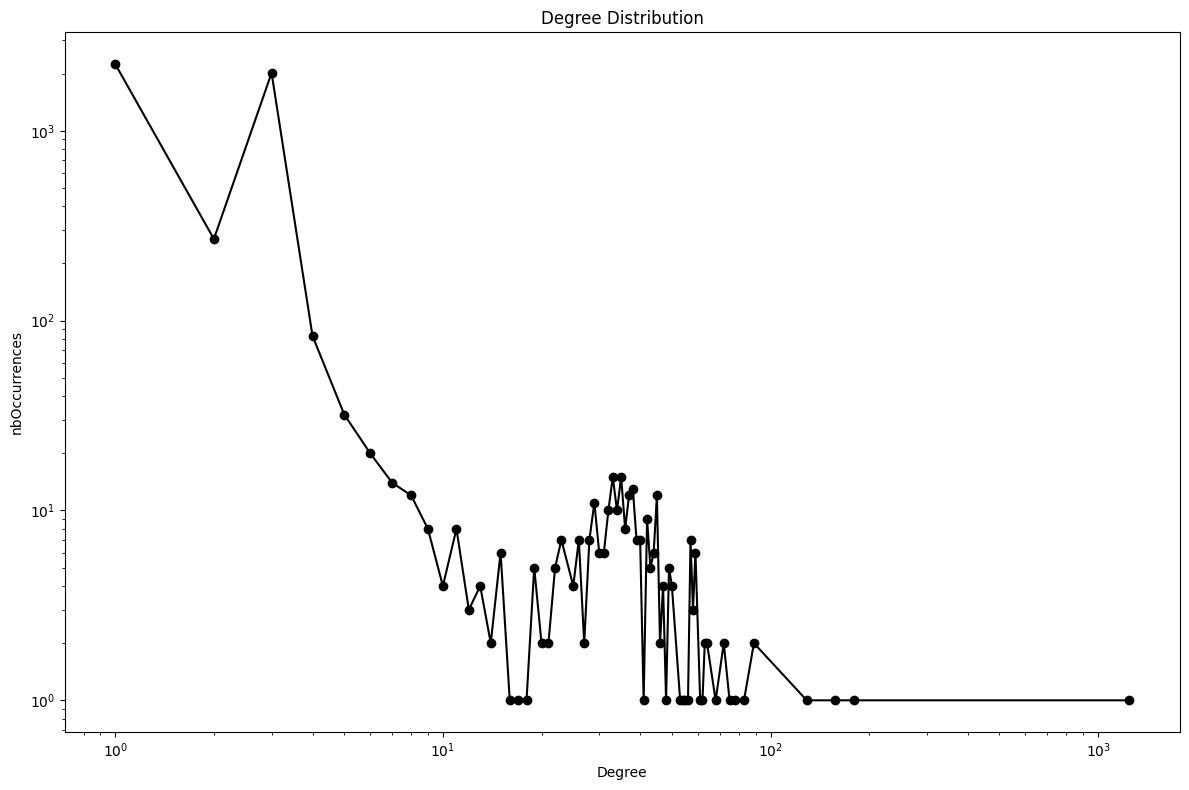

In [ ]:
with group_driver.session() as s:
    # degree_data = s.execute_read(get_degrees, "BusinessLocation", "contained_in")
    degree_data = s.execute_read(get_degrees)    
print(degree_data[:3])


data = pd.DataFrame(degree_data)

plot_degree_distribution(data.degree);

### Maps

/tmp/ipykernel_149/2946580479.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(communities_gdf.geometry.centroid.x,
/tmp/ipykernel_149/2946580479.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  communities_gdf.geometry.centroid.y,


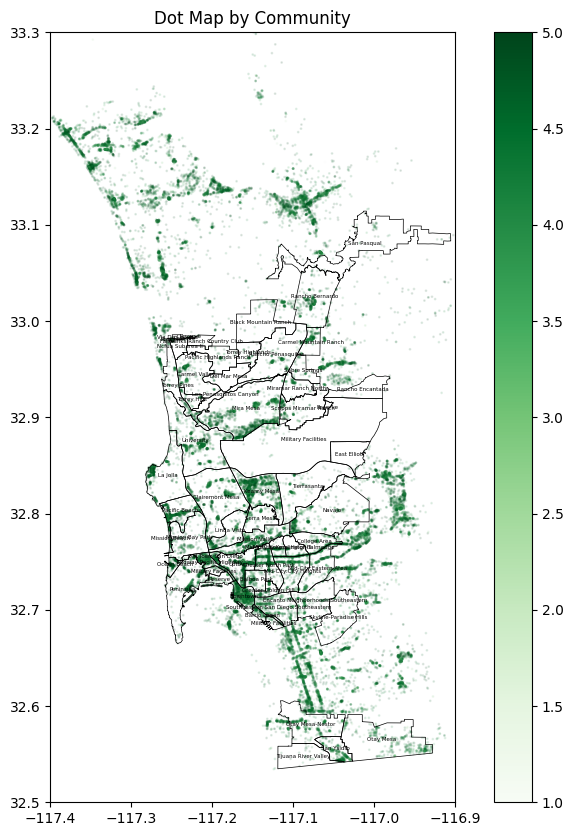

In [33]:
fig1, ax = plt.subplots(figsize=(10, 10))

bus_loc_plot = business_location_gdf.plot(ax=ax,
                                          column='avg_rating',
                                          markersize=1, 
                                          legend =True, 
                                          alpha=0.1,
                                          cmap = 'Greens')# color='purple'


communities_gdf.plot(color = 'none', 
                     ax=ax, 
                     edgecolor='black',
                     linewidth=0.5)#, norm=norm)

bus_loc_plot.set_xlim(-117.4,-116.9)
bus_loc_plot.set_ylim(32.5,33.3)


for x, y, label in zip(communities_gdf.geometry.centroid.x,
                      communities_gdf.geometry.centroid.y,
                      communities_gdf['community']):

        ax.text(x, y, label, fontsize=4, ha='center', va='center')

ax.set_title('Business Dot Map by Community')

plt.show()



/tmp/ipykernel_149/610509852.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
/tmp/ipykernel_149/610509852.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_cities_boundaries_gdf.geometry.centroid.y,


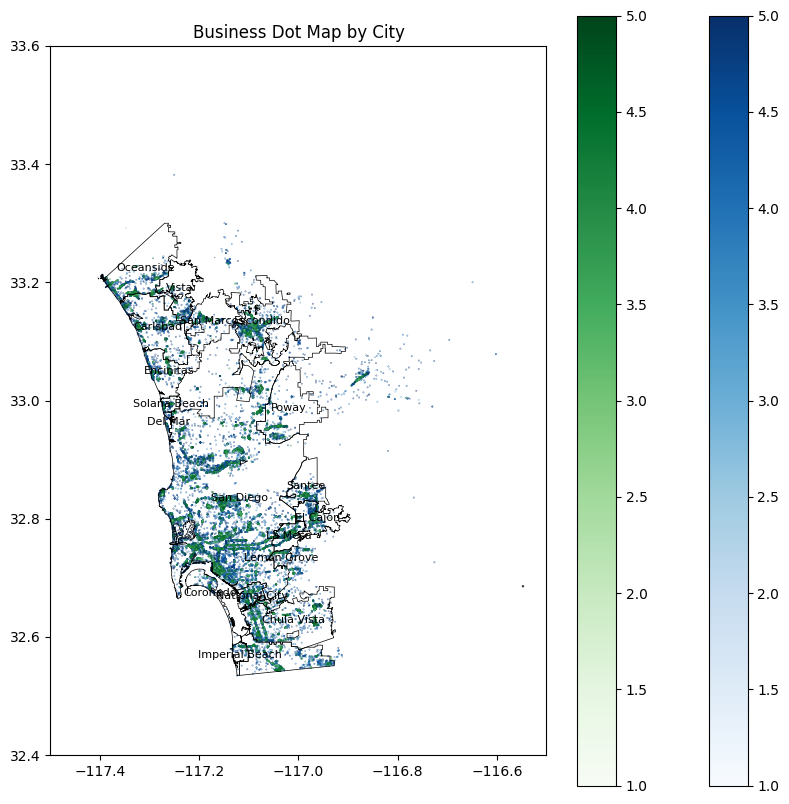

In [34]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
# bus_loc_cities_plot = business_location_gdf.plot(ax=ax2, color='purple',markersize=1, alpha=0.1)

bus_loc_cities_plot = business_location_gdf[business_location_gdf['franchise']=="INDEPENDENT"].plot(ax=ax2,
                                          column='avg_rating',
                                          markersize=0.05, 
                                          legend =True, 
                                          alpha=1,
                                          cmap = 'Blues')# color='purple'

business_location_gdf[business_location_gdf['franchise']=="FRANCHISE"].plot(ax=ax2,
                                          column='avg_rating',
                                          markersize=0.05, 
                                          legend =True, 
                                          alpha=1,
                                          cmap = 'Greens')# color='purple'


sd_cities_boundaries_gdf.plot(color = 'none', ax=ax2, edgecolor='black', linewidth=0.5)#, norm=norm)

bus_loc_cities_plot.set_xlim(-117.5,-116.5)
bus_loc_cities_plot.set_ylim(32.4,33.6)


for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
                      sd_cities_boundaries_gdf.geometry.centroid.y,
                      sd_cities_boundaries_gdf['City']):

        ax2.text(x, y, label, fontsize=8, ha='center', va='center')

ax2.set_title('Business Dot Map by City')

plt.show()



In [49]:
block_group_gdf.dropna(axis=1).describe()

,ctblockgroup,medhinc_cy,avghinc_cy,gini_fy,indmanu_cy,totpop_cy,fem25,fem30,fem35,male25,...,crmcytotc,di100_cy,di150_cy,countyfp,tractce,population,apportionm,blkgrpce,ogc_fid,statefp
count,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,...,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2.085000e+03,2085.000,2085.000000,2085.000000,2085.0
mean,126022.392806,100628.615348,132083.483933,31.424604,75.781295,1614.615348,60.197122,63.650839,55.697362,65.170264,...,99.938129,130.030216,44.665707,72.355396,12602.033573,2.191000e+00,2.576,2.057074,1027.160192,6.0
std,60023.031904,42435.403584,57229.045532,7.596515,68.343557,1094.450412,55.467080,43.311618,33.515960,97.740089,...,70.338021,83.489242,46.960953,5.526313,6002.307700,4.441957e-16,0.000,1.023760,590.159224,0.0
min,1001.000000,0.000000,0.000000,0.000000,0.000000,14.000000,2.000000,2.000000,0.000000,1.000000,...,5.000000,0.000000,0.000000,25.000000,100.000000,2.191000e+00,2.576,1.000000,1.000000,6.0
25%,83504.000000,66989.000000,89399.000000,26.100000,29.000000,1090.000000,33.000000,37.000000,35.000000,34.000000,...,47.000000,74.000000,12.000000,73.000000,8350.000000,2.191000e+00,2.576,1.000000,522.000000,6.0
50%,133223.000000,98573.000000,122558.000000,30.900000,59.000000,1468.000000,52.000000,57.000000,50.000000,54.000000,...,83.000000,115.000000,31.000000,73.000000,13322.000000,2.191000e+00,2.576,2.000000,1015.000000,6.0
75%,178014.000000,124728.000000,164230.000000,36.200000,102.000000,1965.000000,78.000000,82.000000,70.000000,82.000000,...,138.000000,173.000000,64.000000,73.000000,17801.000000,2.191000e+00,2.576,3.000000,1536.000000,6.0
max,221024.000000,200001.000000,422158.000000,63.200000,619.000000,37603.000000,1949.000000,1097.000000,599.000000,3906.000000,...,588.000000,969.000000,499.000000,73.000000,22102.000000,2.191000e+00,2.576,7.000000,2057.000000,6.0


/tmp/ipykernel_149/1903866456.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(block_group_sample_gdf.geometry.centroid.x,
/tmp/ipykernel_149/1903866456.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  block_group_sample_gdf.geometry.centroid.y,
/tmp/ipykernel_149/1903866456.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
/tmp/ipykernel_149/1903866456.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_c

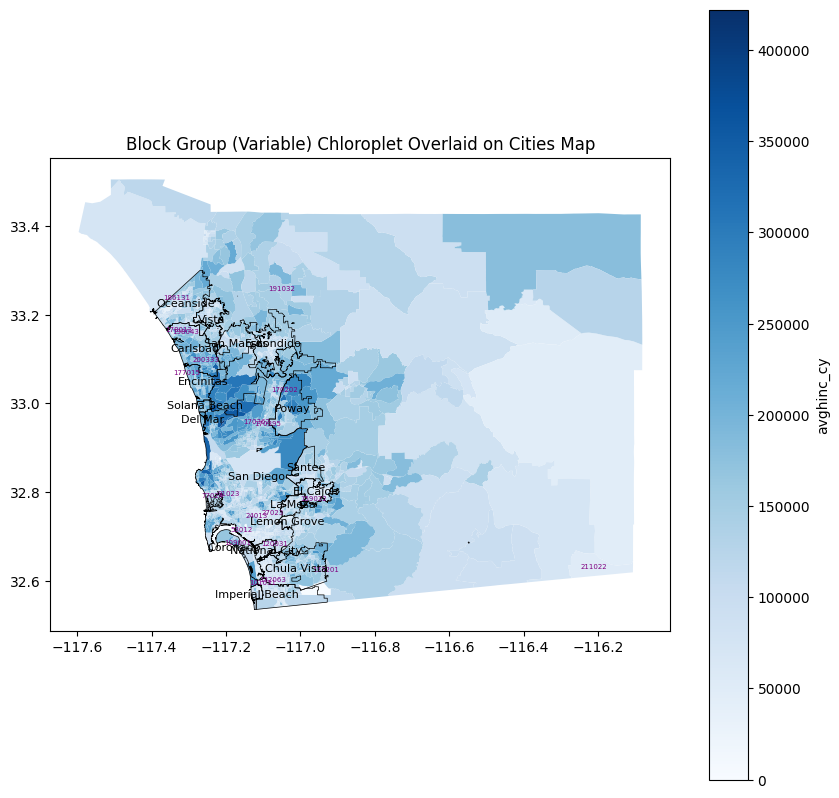

In [65]:


fig3, ax3 = plt.subplots(figsize=(10, 10))

bg_plot_var = 'avghinc_cy'# 'n37_sales'
blockgroup_cities_plot = block_group_gdf.plot(ax=ax3,
                                          column=bg_plot_var,
                                          markersize=0.05, 
                                          legend =True, legend_kwds={'label': bg_plot_var},
                                          alpha=1,
                                          cmap = 'Blues')# color='purple'



sd_cities_boundaries_gdf.plot(color = 'none', ax=ax3, edgecolor='black', linewidth=0.5)#, norm=norm)

#use a sample to add the block group names since there are so many
block_group_sample_gdf = block_group_gdf.sample(frac=0.01, random_state=42)
for x, y, label in zip(block_group_sample_gdf.geometry.centroid.x,
                      block_group_sample_gdf.geometry.centroid.y,
                      block_group_sample_gdf['ctblockgroup']):

        ax3.text(x, y, label, fontsize=5, ha='center', va='center', color='purple')


for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
                      sd_cities_boundaries_gdf.geometry.centroid.y,
                      sd_cities_boundaries_gdf['City']):

        ax3.text(x, y, label, fontsize=8, ha='center', va='center')

ax3.set_title('Block Group (Variable) Chloroplet Overlaid on Cities Map')

plt.show()


/tmp/ipykernel_149/565071665.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
/tmp/ipykernel_149/565071665.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_cities_boundaries_gdf.geometry.centroid.y,


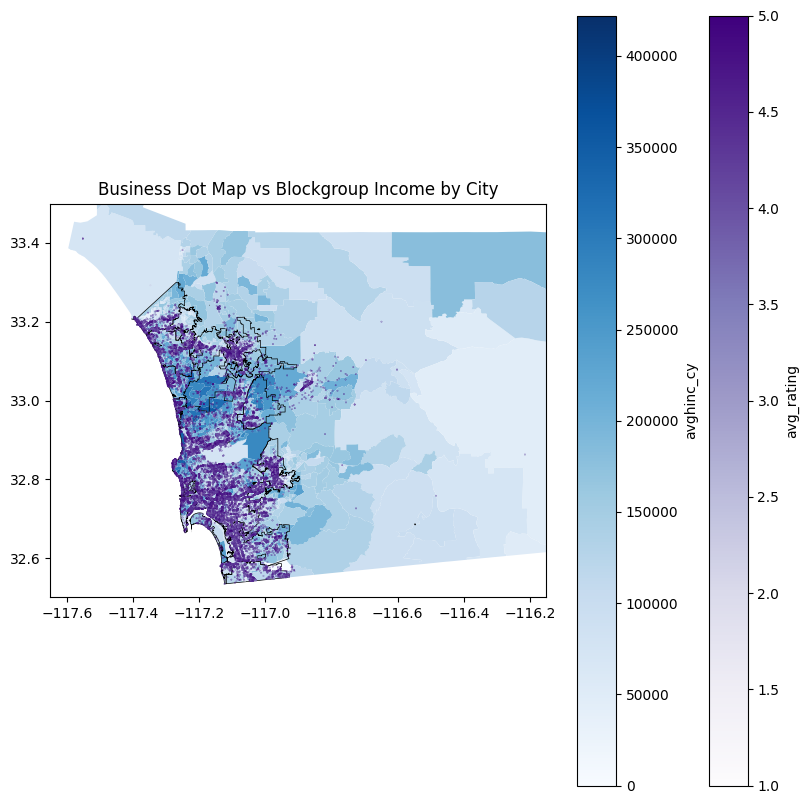

In [77]:
fig4, ax4 = plt.subplots(figsize=(10, 10))
# bus_loc_cities_plot = business_location_gdf.plot(ax=ax2, color='purple',markersize=1, alpha=0.1)

bus_plot_var = 'avg_rating'
bus_bg_cities_plot = business_location_gdf.sample(frac=1,random_state=42).plot(ax=ax4,
                                          column=bus_plot_var,
                                          markersize=0.05, 
                                          legend =True, legend_kwds={'label': bus_plot_var},
                                          alpha=1,
                                          cmap = 'Purples',zorder= 10)# color='purple'



bg_plot_var = 'avghinc_cy'# 'n37_sales'
blockgroup_cities_plot = block_group_gdf.plot(ax=ax4,
                                          column=bg_plot_var,
                                          markersize=0.05, 
                                          legend =True, legend_kwds={'label': bg_plot_var},
                                          alpha=1,
                                          cmap = 'Blues')# color='purple'

sd_cities_boundaries_gdf.plot(color = 'none', ax=ax4, edgecolor='black', linewidth=0.5)#, norm=norm)

bus_bg_cities_plot.set_xlim(-117.65,-116.15)
bus_bg_cities_plot.set_ylim(32.5,33.5)


for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
                      sd_cities_boundaries_gdf.geometry.centroid.y,
                      sd_cities_boundaries_gdf['City']):

        ax2.text(x, y, label, fontsize=8, ha='center', va='center')

ax4.set_title('Business Dot Map vs Blockgroup Income by City')

plt.show()

